# Federalist Papers Authorship Analysis

Analyzing the authorship of disputed Federalist Papers using computational text analysis methods.

The Federalist Papers are 85 essays written in 1787-1788 by Alexander Hamilton, James Madison, and John Jay. While most authorship is known, 12 papers remain disputed between Hamilton and Madison.

This analysis uses:
- Unigram analysis with log-odds ratios
- Bigram patterns
- Sentiment analysis

Let's see if we can figure out who wrote the disputed papers.

## Predict disputed papers with unigrams

Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


Load data

In [2]:
federalist = pd.read_csv('federalist.csv')
print(f"\nTotal papers: {len(federalist)}")
print(f"\nColumns: {list(federalist.columns)}")
federalist.head()


Total papers: 85

Columns: ['author', 'text', 'date', 'title', 'paper_id', 'venue']


,author,text,date,title,paper_id,venue
0,HAMILTON,To the People of the State of New York:\r\n\r\...,NaN,General Introduction,1,For the Independent Journal
1,JAY,To the People of the State of New York:\r\n\r\...,NaN,Concerning Dangers from Foreign Force and Infl...,2,For the Independent Journal
2,JAY,To the People of the State of New York:\r\n\r\...,NaN,The Same Subject Continued (Concerning Dangers...,3,For the Independent Journal
3,JAY,To the People of the State of New York:\r\n\r\...,NaN,The Same Subject Continued (Concerning Dangers...,4,For the Independent Journal
4,JAY,To the People of the State of New York:\r\n\r\...,NaN,The Same Subject Continued (Concerning Dangers...,5,For the Independent Journal


Identify disputed papers

In [3]:
# Check the distribution of authors
print(federalist['author'].value_counts())

# Identify disputed papers
disputed = federalist[federalist['author'] == 'HAMILTON OR MADISON']
print(f"Number of disputed papers: {len(disputed)}")
print(f"Paper IDs: {list(disputed['paper_id'].values)}")

author
HAMILTON                51
MADISON                 15
HAMILTON OR MADISON     11
JAY                      5
HAMILTON AND MADISON     3
Name: count, dtype: int64
Number of disputed papers: 11
Paper IDs: [49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63]


More papers written by Hamilton. 11 papers are disputed that needs author to be assigned.

Text Preprocessing

Lets do text preprocessing by converting text to lowercase, removing newlines and carriage returns and removing punctuation. I will keep only words and spaces

In [4]:
# Preprocess the text
federalist['clean_text'] = (
    federalist['text']
    .str.lower()                              # convert to lowercase
    .str.replace(r'\n', ' ', regex=True)      # replace newlines with space
    .str.replace(r'\r', ' ', regex=True)      # replace carriage returns
    .str.replace(r'[^\w\s]', '', regex=True)  # remove punctuation
)

# Calculate total number of words
federalist['text_length'] = federalist['clean_text'].apply(lambda x: len(x.split()))


print(f"\nExample original text :")
print(federalist.iloc[0]['text'][:200])
print(f"\nExample cleaned text:")
print(federalist.iloc[0]['clean_text'][:200])


Example original text :
To the People of the State of New York:

AFTER an unequivocal experience of the inefficacy of the
subsisting federal government, you are called upon to deliberate on
a new Constitution for the Uni

Example cleaned text:
to the people of the state of new york    after an unequivocal experience of the inefficacy of the  subsisting federal government you are called upon to deliberate on  a new constitution for the unite


Lets now choose discriminative words. To do so we need to find the words used by authors at different rates. 


Method:
1. Count all words for each author
2. Calculate relative frequencies (per 1000 words) - this normalizes for different text lengths
3. Compute the ratio: How many times more does one author use this word?
4. Select words with:High frequency (appear at least 10 times), NOT common stopwords (like "the", "a", "is"), Clear difference between authors


If ratio > 1: Hamilton uses it more  
If ratio < 1: Madison uses it more

In [5]:
# Extract text for each author (only known authors, not disputed)
hamilton_text = ' '.join(federalist[federalist['author'] == 'HAMILTON']['clean_text'].values)
madison_text = ' '.join(federalist[federalist['author'] == 'MADISON']['clean_text'].values)
jay_text = ' '.join(federalist[federalist['author'] == 'JAY']['clean_text'].values)

# Count all words using Counter
hamilton_words = Counter(hamilton_text.split())
madison_words = Counter(madison_text.split())
jay_words = Counter(jay_text.split())

# Total word counts
hamilton_total = sum(hamilton_words.values())
madison_total = sum(madison_words.values())
jay_total = sum(jay_words.values())

print(f"\nHamilton total words: {hamilton_total:,}")
print(f"Madison total words: {madison_total:,}")
print(f"Jay total words: {jay_total:,}")

# Common stopwords - non distinguishing words
stopwords = {'the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'that', 'for', 
             'as', 'with', 'was', 'be', 'are', 'have', 'this', 'has', 'or',
             'will', 'not', 'but', 'from', 'they', 'which', 'on', 'at', 'an',
             'been', 'their', 'may', 'would', 'can', 'were', 'who', 'all',
             'there', 'if', 'more', 'these', 'its', 'had', 'should', 'such'}

starter_words = {'man', 'by', 'upon'}

# Find discriminative words
candidates = []

for word in set(list(hamilton_words.keys()) + list(madison_words.keys())):
    if word in stopwords or word in starter_words:
        continue
    
    h_count = hamilton_words.get(word, 0)
    m_count = madison_words.get(word, 0)
    
    # Must appear at least 10 times for at least one author
    if h_count < 10 and m_count < 10:
        continue
    
    # Calculate per 1000 words (relative frequency)
    h_freq = (h_count / hamilton_total) * 1000
    m_freq = (m_count / madison_total) * 1000
    
    # Calculate ratio
    if m_freq > 0.01:
        ratio = h_freq / m_freq
    else:
        ratio = 100 if h_freq > 0 else 1
    
    # Absolute difference
    difference = abs(h_freq - m_freq)
    
    candidates.append({
        'word': word,
        'hamilton_count': h_count,
        'madison_count': m_count,
        'hamilton_per_1000': h_freq,
        'madison_per_1000': m_freq,
        'ratio': ratio,
        'difference': difference
    })

# Convert to dataframe and sort by difference
df_candidates = pd.DataFrame(candidates)
df_candidates = df_candidates.sort_values('difference', ascending=False)
display(df_candidates.head(30))



Hamilton total words: 113,026
Madison total words: 40,980
Jay total words: 8,418


,word,hamilton_count,madison_count,hamilton_per_1000,madison_per_1000,ratio,difference
93,states,458,261,4.052165,6.368960,0.636236,2.316795
392,powers,98,127,0.867057,3.099073,0.279780,2.232016
837,government,418,235,3.698264,5.734505,0.644914,2.036241
1201,constitution,239,153,2.114558,3.733529,0.566370,1.618971
251,federal,137,110,1.212110,2.684236,0.451566,1.472126
1196,legislative,83,86,0.734344,2.098585,0.349924,1.364240
222,department,19,57,0.168103,1.390922,0.120857,1.222819
616,executive,127,94,1.123635,2.293802,0.489857,1.170167
87,people,271,146,2.397678,3.562714,0.672992,1.165035
361,confederation,23,55,0.203493,1.342118,0.151621,1.138625


Let me export it and see which additional words to choose

In [6]:
#df_candidates.to_csv('discriminative_words.csv', index=False)

5 additional words are whilst (Madison's uses 33 times more), courts (Hamilton's uses 11 times more), powers(Madison favors), congress (Madison favors), any (Hamilton favors). 3 words from class man, by, upon

Lets now count how often these 8 words in each paper

In [7]:
# Our final 8 words
selected_words = ['man', 'by', 'upon', 'whilst', 'courts', 'powers', 'congress', 'any']

# Count each word in each paper
for word in selected_words:
    col_name = f'{word}_count'
    federalist[col_name] = federalist['clean_text'].str.count(rf'\b{word}\b') # To match whole words only


Lets calculate now author probabilities. For example: 

$$\hat{\mu}_{\text{hamilton, man}} = \frac{\text{total count of man by hamilton}}{\text{total words by hamilton}}$$

In [8]:
# Filter only non disputed
known = federalist[federalist['author'].isin(['HAMILTON', 'MADISON', 'JAY'])]

# Calculate total counts for each author
word_count_cols = [f'{w}_count' for w in selected_words]

# Group by author and sum
author_word_counts = known.groupby('author')[word_count_cols + ['text_length']].sum()


# Calculate probabilities
# For each word, divide count by total text length
mu_hamilton = {}
mu_madison = {}
mu_jay = {}

for word in selected_words:
    col = f'{word}_count'
    
    mu_hamilton[word] = author_word_counts.loc['HAMILTON', col] / author_word_counts.loc['HAMILTON', 'text_length']
    mu_madison[word] = author_word_counts.loc['MADISON', col] / author_word_counts.loc['MADISON', 'text_length']
    mu_jay[word] = author_word_counts.loc['JAY', col] / author_word_counts.loc['JAY', 'text_length']

# Convert to Series for easier handling
mu_hamilton = pd.Series(mu_hamilton)
mu_madison = pd.Series(mu_madison)
mu_jay = pd.Series(mu_jay)

# Create a comparison dataframe
mu_comparison = pd.DataFrame({
    'Hamilton': mu_hamilton,
    'Madison': mu_madison,
    'Jay': mu_jay
})


display(mu_comparison * 100)



,Hamilton,Madison,Jay
man,0.090245,0.041484,0.000000
by,0.760002,1.156662,0.974103
upon,0.330897,0.017082,0.011879
whilst,0.000885,0.029283,0.000000
courts,0.105286,0.009761,0.047517
powers,0.086706,0.309907,0.059397
congress,0.034505,0.143973,0.083155
any,0.322935,0.209858,0.261345


Lets compute posterier probabilities for disputed papers

In [9]:
#log likelihood -> likelihood -> posterior
def calculate_posterior_probabilities(word_counts, mu_hamilton, mu_madison, mu_jay):
    # Calculate log-likelihood for each author
    # log P(words | author) = sum of (count_i * log(probability_i))
    
    log_likelihood_hamilton = 0
    log_likelihood_madison = 0
    log_likelihood_jay = 0
    
    for word in selected_words:
        count = word_counts[word]
        
        # Add small constant (Laplace smoothing) to avoid log(0). This is important if a word never appears
        epsilon = 1e-10
        
        log_likelihood_hamilton += count * np.log(mu_hamilton[word] + epsilon)
        log_likelihood_madison += count * np.log(mu_madison[word] + epsilon)
        log_likelihood_jay += count * np.log(mu_jay[word] + epsilon)
    
    # Convert log-likelihoods back to likelihoods (for normalization)
    # We use exp, but we'll normalize anyway so relative scale matters
    # To avoid overflow, subtract the maximum
    max_log = max(log_likelihood_hamilton, log_likelihood_madison, log_likelihood_jay)
    
    likelihood_hamilton = np.exp(log_likelihood_hamilton - max_log)
    likelihood_madison = np.exp(log_likelihood_madison - max_log)
    likelihood_jay = np.exp(log_likelihood_jay - max_log)
    
    # Normalize to get posterior probabilities (assuming equal priors)
    total = likelihood_hamilton + likelihood_madison + likelihood_jay
    
    posterior_hamilton = likelihood_hamilton / total
    posterior_madison = likelihood_madison / total
    posterior_jay = likelihood_jay / total
    
    return {
        'P(Hamilton)': posterior_hamilton,
        'P(Madison)': posterior_madison,
        'P(Jay)': posterior_jay
    }


In [10]:
# Get disputed papers
disputed_papers = federalist[federalist['author'] == 'HAMILTON OR MADISON'].copy()

# For each disputed paper, calculate posteriors
results = []

for idx, row in disputed_papers.iterrows():
    paper_id = row['paper_id']
    
    # Get word counts for this paper
    word_counts = {word: row[f'{word}_count'] for word in selected_words}
    word_counts_series = pd.Series(word_counts)
    
    # Calculate posterior probabilities
    posteriors = calculate_posterior_probabilities(
        word_counts_series, 
        mu_hamilton, 
        mu_madison, 
        mu_jay
    )
    
    # Determine predicted author (highest probability)
    predicted_author = max(posteriors, key=posteriors.get).replace('P(', '').replace(')', '')
    
    results.append({
        'Paper_ID': paper_id,
        'P(Hamilton)': posteriors['P(Hamilton)'],
        'P(Madison)': posteriors['P(Madison)'],
        'P(Jay)': posteriors['P(Jay)'],
        'Predicted_Author': predicted_author,
        'Confidence': max(posteriors.values())
    })

# Create results dataframe
results_df = pd.DataFrame(results)
display(results_df)


# Summary

prediction_counts = results_df['Predicted_Author'].value_counts()
for author, count in prediction_counts.items():
    print(f"{author}: {count} papers")
    
print(f"\nAverage confidence: {results_df['Confidence'].mean():.2%}")

,Paper_ID,P(Hamilton),P(Madison),P(Jay),Predicted_Author,Confidence
0,49,7.491977e-05,0.999925,1.070293e-22,Madison,0.999925
1,50,5.561341e-01,0.337583,1.062834e-01,Hamilton,0.556134
2,51,4.271778e-09,1.000000,4.741830e-24,Madison,1.000000
3,52,4.480010e-04,0.941828,5.772438e-02,Madison,0.941828
4,53,1.009024e-06,0.999999,2.081246e-22,Madison,0.999999
5,54,6.749491e-02,0.932505,3.351864e-09,Madison,0.932505
6,55,8.024488e-05,0.988904,1.101533e-02,Madison,0.988904
7,56,9.363554e-04,0.999064,1.059289e-07,Madison,0.999064
8,57,1.782806e-09,1.000000,3.155263e-35,Madison,1.000000
9,62,1.767392e-05,0.999982,2.691887e-10,Madison,0.999982


Madison: 10 papers
Hamilton: 1 papers

Average confidence: 94.71%


## Logged Odds Differences for Bigrams

Stopwords


In [11]:
stopwords = {
    'the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'that', 'for',
    'as', 'with', 'was', 'be', 'are', 'have', 'this', 'has', 'or',
    'will', 'not', 'but', 'from', 'they', 'which', 'on', 'at', 'an',
    'been', 'their', 'may', 'would', 'can', 'were', 'who', 'all',
    'there', 'if', 'more', 'these', 'its', 'had', 'should', 'such',
    'by', 'than', 'them', 'into', 'only', 'other', 'some', 'could',
    'our', 'no', 'up', 'so', 'when', 'what', 'out', 'any', 'after',
    'very', 'much', 'then', 'how', 'now', 'also', 'well', 'being',
    'both', 'each', 'those', 'between', 'under', 'through', 'during'
}

Bigram function

In [12]:
def create_bigrams(text, remove_stopwords=True):

    words = text.split()
    bigrams = []
    
    for i in range(len(words) - 1):
        word1, word2 = words[i], words[i + 1]
        
        # Skip if either word is a stopword
        if remove_stopwords:
            if word1 in stopwords or word2 in stopwords:
                continue
        
        bigrams.append((word1, word2))
    
    return bigrams

Extracting bigrams for Hamilton and Madison 

In [13]:

# Get text for each author (only known papers)
hamilton_text = ' '.join(
    federalist[federalist['author'] == 'HAMILTON']['clean_text'].values
)
madison_text = ' '.join(
    federalist[federalist['author'] == 'MADISON']['clean_text'].values
)

# Create bigrams
hamilton_bigrams = create_bigrams(hamilton_text, remove_stopwords=True)
madison_bigrams = create_bigrams(madison_text, remove_stopwords=True)

print(f"Hamilton bigrams: {len(hamilton_bigrams)}")
print(f"Madison bigrams: {len(madison_bigrams)}")

Hamilton bigrams: 17870
Madison bigrams: 6739


Counting frequencies

In [14]:
from collections import Counter

hamilton_bigram_counts = Counter(hamilton_bigrams)
madison_bigram_counts = Counter(madison_bigrams)

Removing bigrams only appearing once

In [15]:
hamilton_bigram_counts = {
    bg: cnt for bg, cnt in hamilton_bigram_counts.items() if cnt > 1
}
madison_bigram_counts = {
    bg: cnt for bg, cnt in madison_bigram_counts.items() if cnt > 1
}

Calculating Relative frequencies

In [16]:
# Total counts
hamilton_total = sum(hamilton_bigram_counts.values())
madison_total = sum(madison_bigram_counts.values())

print(f"\nHamilton total: {hamilton_total:,}")
print(f"Madison total: {madison_total:,}")

# Relative frequencies
hamilton_freq = {bg: cnt/hamilton_total for bg, cnt in hamilton_bigram_counts.items()}
madison_freq = {bg: cnt/madison_total for bg, cnt in madison_bigram_counts.items()}


Hamilton total: 6,236
Madison total: 1,811


Calculating log odds differences: log_odds(Hamilton) - log_odds(Madison).

Positive means Hamilton uses more. Negative means Madison uses more.

In [17]:
def calculate_log_odds(freq):
    epsilon = 1e-10 #avoid log(0)
    f = max(min(freq, 1 - epsilon), epsilon) #clipping
    return np.log(f / (1 - f))

# Get all unique bigrams
all_bigrams = set(hamilton_freq.keys()) | set(madison_freq.keys())

# Calculate differences
log_odds_diff = {}

for bigram in all_bigrams:
    h_freq = hamilton_freq.get(bigram, 1e-10)
    m_freq = madison_freq.get(bigram, 1e-10)
    
    h_log_odds = calculate_log_odds(h_freq)
    m_log_odds = calculate_log_odds(m_freq)
    
    delta = h_log_odds - m_log_odds
    
    log_odds_diff[bigram] = {
        'hamilton_count': hamilton_bigram_counts.get(bigram, 0),
        'madison_count': madison_bigram_counts.get(bigram, 0),
        'log_odds_diff': delta
    }


df_bigrams = pd.DataFrame.from_dict(log_odds_diff, orient='index')
df_bigrams['bigram'] = df_bigrams.index
df_bigrams = df_bigrams.reset_index(drop=True)

Plotting the log odds differences of the top discriminative bigrams.

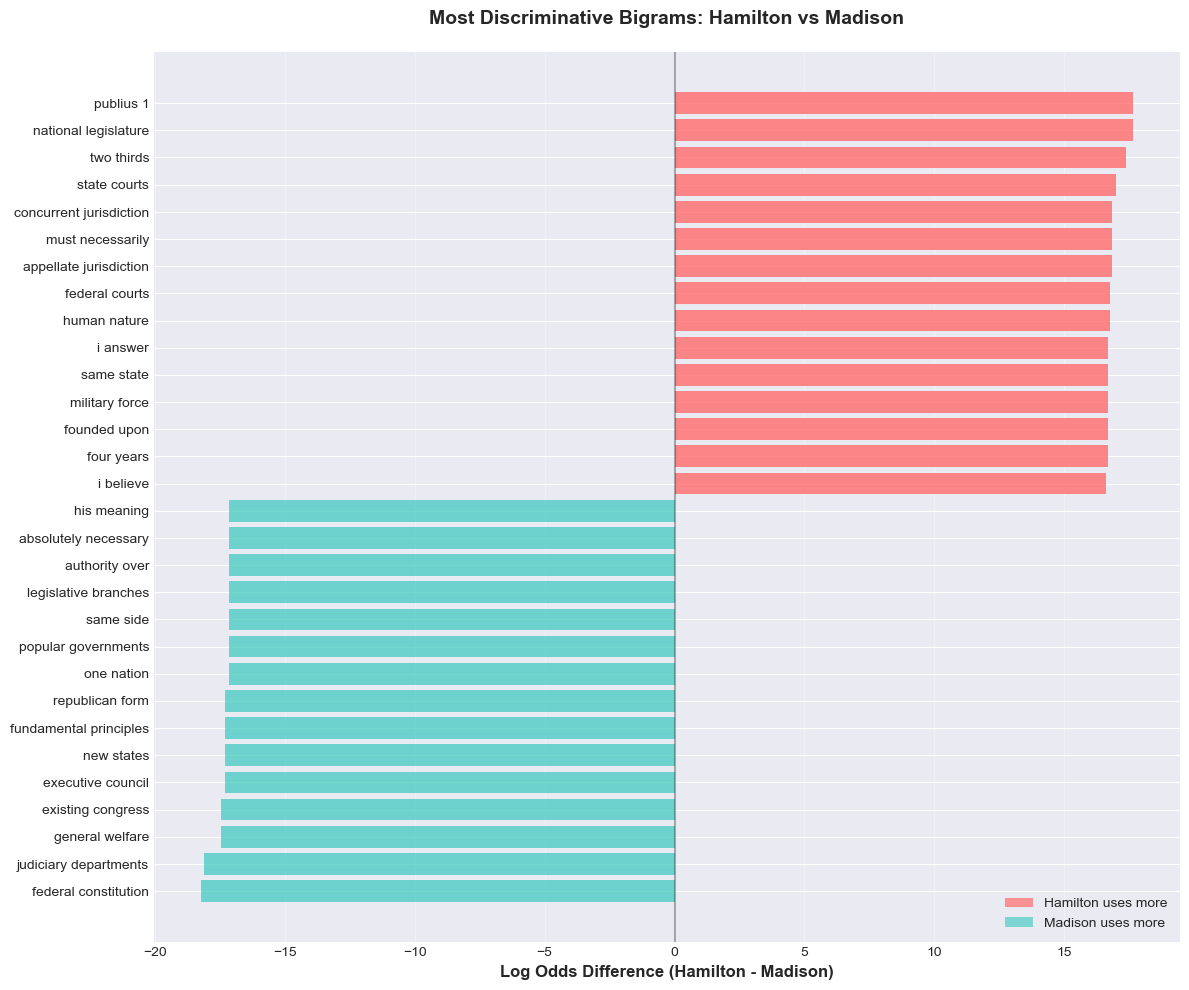

In [18]:

# Create readable bigram strings
df_bigrams['bigram_str'] = df_bigrams['bigram'].apply(lambda x: f"{x[0]} {x[1]}")

# Sort by absolute difference
df_bigrams['abs_diff'] = df_bigrams['log_odds_diff'].abs()
df_bigrams = df_bigrams.sort_values('abs_diff', ascending=False)

# Select top bigrams for each author
n_top = 15

top_hamilton = df_bigrams[df_bigrams['log_odds_diff'] > 0].head(n_top)
top_madison = df_bigrams[df_bigrams['log_odds_diff'] < 0].head(n_top)

top_bigrams = pd.concat([top_hamilton, top_madison]).sort_values('log_odds_diff')

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in top_bigrams['log_odds_diff']]

ax.barh(range(len(top_bigrams)), top_bigrams['log_odds_diff'], color=colors, alpha=0.8)

ax.set_yticks(range(len(top_bigrams)))
ax.set_yticklabels(top_bigrams['bigram_str'], fontsize=10)
ax.set_xlabel('Log Odds Difference (Hamilton - Madison)', fontsize=12, fontweight='bold')
ax.set_title('Most Discriminative Bigrams: Hamilton vs Madison', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', alpha=0.7, label='Hamilton uses more'),
    Patch(facecolor='#4ECDC4', alpha=0.7, label='Madison uses more')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

The visualization reveals strong phrasal discrimination between Hamilton and Madison as log odds differences ranging from about-18 to +18. Hamilton's distinctive phrases reflect legal terminology like: 'state courts', 'appellate jurisdiction'. While Madison's phrases emphasize constitutional theory like: 'federal constitution', 'general welfare'. The clear left-right separation with no clustering around zero indicates highly distinctive writing styles, making these bigrams powerful features for authorship attribution.

## Dictionary Analysis (Using Built-in Sentiment Lexica)

In [19]:
# Install required packages 
import subprocess
import sys

packages = ['textblob', 'vaderSentiment', 'nltk']

for package in packages:
    try:
        __import__(package)
        print(f"{package} already installed")
    except ImportError:
        print(f"⏳ Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--break-system-packages", "-q"])
        print(f"{package} installed")

# Import libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

# Download required NLTK data

try:
    nltk.download('opinion_lexicon', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("Some NLTK downloads may have failed")

from nltk.corpus import opinion_lexicon


textblob already installed
vaderSentiment already installed
nltk already installed


Intialize sentiment analyzers

In [20]:
#VADER (Valence Aware Dictionary and sEntiment Reasoner)
vader_analyzer = SentimentIntensityAnalyzer()


#NLTK Opinion Lexicon (Bing Liu's lexicon)
positive_words_nltk = set(opinion_lexicon.positive())
negative_words_nltk = set(opinion_lexicon.negative())
print(f"  Positive words: {len(positive_words_nltk)}")
print(f"  Negative words: {len(negative_words_nltk)}")


  Positive words: 2006
  Negative words: 4783


Calculating sentiment using VADER

In [21]:
def get_vader_sentiment(text): 
    scores = vader_analyzer.polarity_scores(text)
    return scores

# Applied VADER sentiment analysis to each text entry, extracting compound, positive, negative, and neutral scores

vader_results = federalist['text'].apply(get_vader_sentiment)  # Using original text as VADER handles punctuation

federalist['vader_compound'] = vader_results.apply(lambda x: x['compound'])
federalist['vader_positive'] = vader_results.apply(lambda x: x['pos'])
federalist['vader_negative'] = vader_results.apply(lambda x: x['neg'])
federalist['vader_neutral'] = vader_results.apply(lambda x: x['neu'])



In [22]:
vader_results.head(1).values

array([{'neg': 0.071, 'neu': 0.747, 'pos': 0.182, 'compound': 0.9997}],
      dtype=object)

Calculating sentiment using TextBlob

In [23]:

def get_textblob_sentiment(text): #returns polarity and subjectivity
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply TextBlob

textblob_results = federalist['text'].apply(get_textblob_sentiment)

federalist['textblob_polarity'] = textblob_results.apply(lambda x: x[0])
federalist['textblob_subjectivity'] = textblob_results.apply(lambda x: x[1])


In [24]:
textblob_results.head(1)

0    (0.1671876291557143, 0.4773855773855771)
Name: text, dtype: object

Analyzing with NLTK opinion lexicon

In [25]:
def count_opinion_words(text, pos_words, neg_words): #Count positive and negative words using NLTK Opinion Lexicon.
    words = text.lower().split()
    positive_count = sum(1 for word in words if word in pos_words)
    negative_count = sum(1 for word in words if word in neg_words)
    return positive_count, negative_count

# Apply Opinion Lexicon
opinion_results = federalist['clean_text'].apply(
    lambda x: count_opinion_words(x, positive_words_nltk, negative_words_nltk)
)

federalist['nltk_positive_count'] = opinion_results.apply(lambda x: x[0])
federalist['nltk_negative_count'] = opinion_results.apply(lambda x: x[1])

# Calculate rates per 1000 words -> Normalize by text length
federalist['text_length'] = federalist['clean_text'].apply(lambda x: len(x.split()))
federalist['nltk_positive_rate'] = (federalist['nltk_positive_count'] / federalist['text_length']) * 1000
federalist['nltk_negative_rate'] = (federalist['nltk_negative_count'] / federalist['text_length']) * 1000

# NLTK sentiment score
federalist['nltk_sentiment'] = federalist['nltk_positive_rate'] - federalist['nltk_negative_rate']



In [26]:
federalist.head(1)

,author,text,date,title,paper_id,venue,clean_text,text_length,man_count,by_count,...,vader_positive,vader_negative,vader_neutral,textblob_polarity,textblob_subjectivity,nltk_positive_count,nltk_negative_count,nltk_positive_rate,nltk_negative_rate,nltk_sentiment
0,HAMILTON,To the People of the State of New York:\r\n\r\...,NaN,General Introduction,1,For the Independent Journal,to the people of the state of new york afte...,1617,0,14,...,0.182,0.071,0.747,0.167188,0.477386,70,59,43.290043,36.487322,6.802721


Averages by Author

In [27]:
# Get only known authors
known_papers = federalist[federalist['author'].isin(['HAMILTON', 'MADISON', 'JAY'])]

# Calculate averages by author
author_sentiment = known_papers.groupby('author').agg({
    'vader_compound': ['mean', 'std'],
    'textblob_polarity': ['mean', 'std'],
    'textblob_subjectivity': ['mean', 'std'],
    'nltk_sentiment': ['mean', 'std'],
    'nltk_positive_rate': 'mean',
    'nltk_negative_rate': 'mean'
}).round(3)



In [28]:

# Simplified view
author_summary = known_papers.groupby('author').agg({
    'vader_compound': 'mean',
    'textblob_polarity': 'mean',
    'textblob_subjectivity': 'mean',
    'nltk_sentiment': 'mean'
}).round(3)


for author in ['HAMILTON', 'MADISON', 'JAY']:
    if author not in author_summary.index:
        continue
    print(f"\n{author}:")
    print(f"  VADER compound: {author_summary.loc[author, 'vader_compound']:.3f} (-1 to +1)")
    print(f"  TextBlob polarity: {author_summary.loc[author, 'textblob_polarity']:.3f} (-1 to +1)")
    print(f"  TextBlob subjectivity: {author_summary.loc[author, 'textblob_subjectivity']:.3f} (0 to 1)")
    print(f"  NLTK sentiment: {author_summary.loc[author, 'nltk_sentiment']:.3f} (per 1000 words)")



HAMILTON:
  VADER compound: 0.994 (-1 to +1)
  TextBlob polarity: 0.105 (-1 to +1)
  TextBlob subjectivity: 0.465 (0 to 1)
  NLTK sentiment: 2.269 (per 1000 words)

MADISON:
  VADER compound: 0.998 (-1 to +1)
  TextBlob polarity: 0.106 (-1 to +1)
  TextBlob subjectivity: 0.432 (0 to 1)
  NLTK sentiment: 5.449 (per 1000 words)

JAY:
  VADER compound: 0.999 (-1 to +1)
  TextBlob polarity: 0.183 (-1 to +1)
  TextBlob subjectivity: 0.475 (0 to 1)
  NLTK sentiment: 26.683 (per 1000 words)


VADER Compound Score Distribution

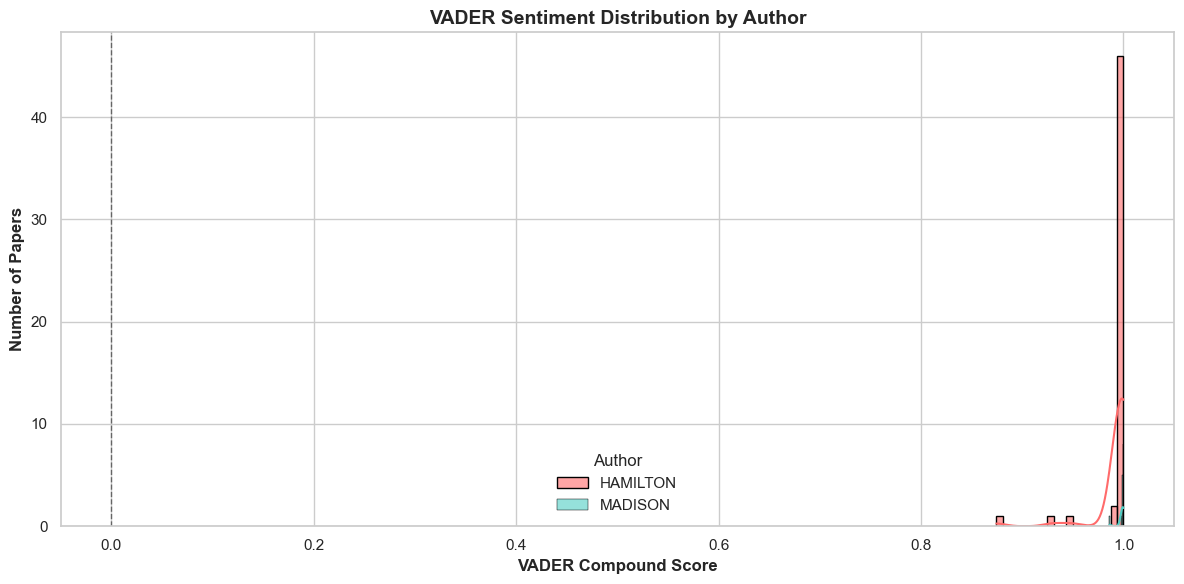

In [29]:

# Set Seaborn style for cleaner visuals
sns.set(style='whitegrid')

authors_list = ['HAMILTON', 'MADISON'] #Lets focus on two authors for clarity
colors = ['#FF6B6B', '#4ECDC4']

plt.figure(figsize=(12, 6))
for author, color in zip(authors_list, colors):
    author_data = known_papers[known_papers['author'] == author]['vader_compound']
    sns.histplot(author_data, bins=20, kde=True, color=color, label=author, stat='count', alpha=0.6, edgecolor='black')

# Add vertical line at neutral threshold
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Axis labels and title
plt.xlabel('VADER Compound Score', fontsize=12, fontweight='bold')
plt.ylabel('Number of Papers', fontsize=12, fontweight='bold')
plt.title('VADER Sentiment Distribution by Author', fontsize=14, fontweight='bold')

# Legend and layout
plt.legend(title='Author')
plt.tight_layout()
plt.show()

Most papers by Hamilton, Madison, and show strongly positive sentiment, with VADER compound scores clustering near 1. Hamilton's texts dominate the high-score range, suggesting a consistently upbeat or affirming tone. Both authors show no papers with negative VADER sentiment, indicating their political writings maintain a positive rhetorical tone.

TextBlob Polarity Distribution

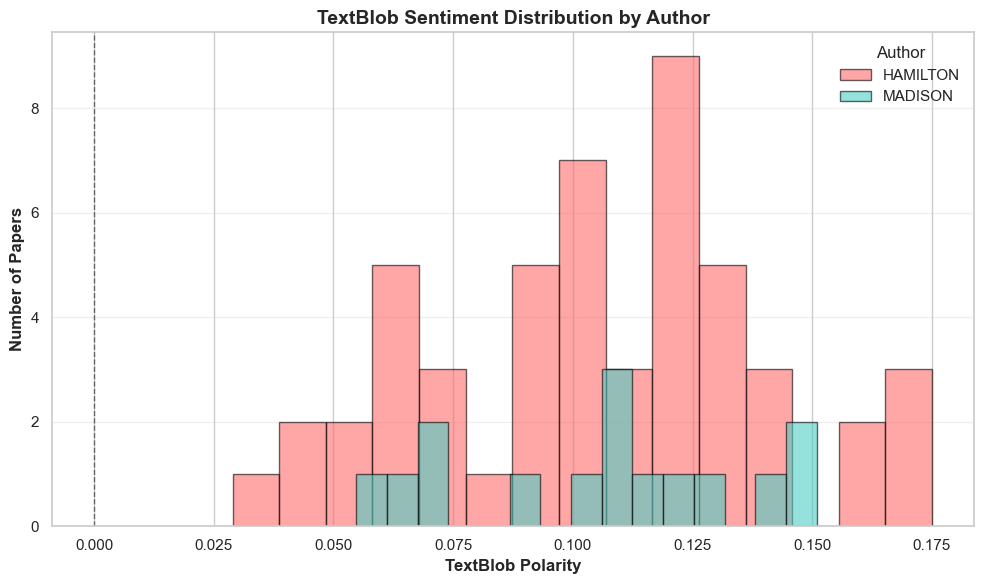

In [30]:

plt.figure(figsize=(10, 6))
for author, color in zip(authors_list, colors):
    author_data = known_papers[known_papers['author'] == author]['textblob_polarity']
    plt.hist(author_data, bins=15, alpha=0.6, label=author, color=color, edgecolor='black')

plt.xlabel('TextBlob Polarity', fontsize=12, fontweight='bold')
plt.ylabel('Number of Papers', fontsize=12, fontweight='bold')
plt.title('TextBlob Sentiment Distribution by Author', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(title='Author')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Hamilton’s papers show consistently higher TextBlob polarity scores than Madison’s, suggesting a more positive tone overall. Both authors cluster in the low-to-mid positive range with no texts registering neutral or negative sentiment. This pattern confirms VADER's findings, establishing a consistent picture from contextual sentiment methods.

NLTK Sentiment Distribution

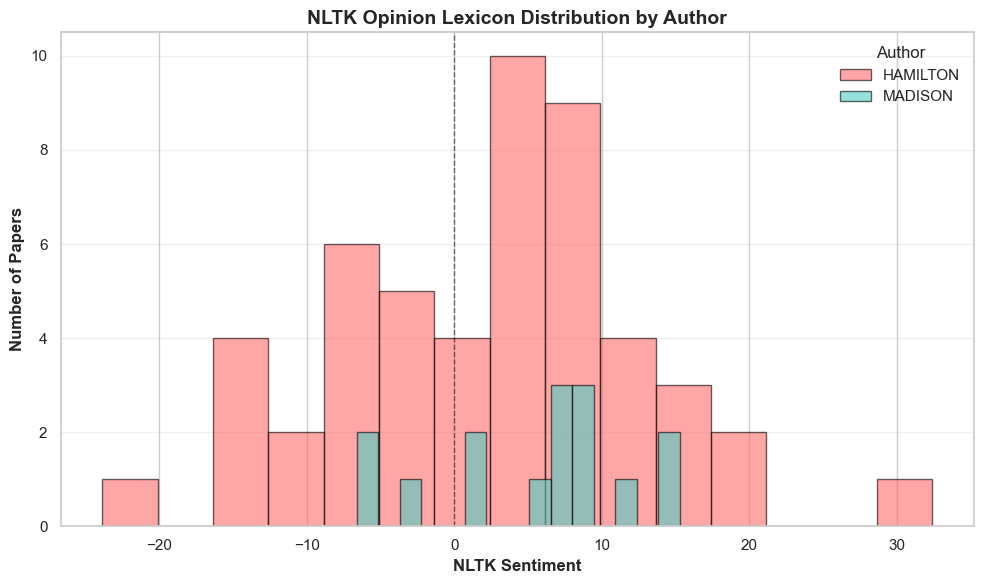

In [38]:
plt.figure(figsize=(10, 6))
for author, color in zip(authors_list, colors):
    author_data = known_papers[known_papers['author'] == author]['nltk_sentiment']
    plt.hist(author_data, bins=15, alpha=0.6, label=author, color=color, edgecolor='black')

plt.xlabel('NLTK Sentiment', fontsize=12, fontweight='bold')
plt.ylabel('Number of Papers', fontsize=12, fontweight='bold')
plt.title('NLTK Opinion Lexicon Distribution by Author', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(title='Author')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Hamilton and Madison's papers show a wider sentiment range under the NLTK lexicon including several with negative scores. This is different from the consistently positive results from VADER and TextBlob. Notably, Hamilton has more papers with negative NLTK scores than Madison despite appearing more positive in VADER and TextBlob. Because VADER and TextBlob normalize sentiment and are tuned for general positivity in formal or neutral texts while NLTK Opinion Lexicon uses raw word counts from a fixed positive/negative list, making it more sensitive to isolated negative terms. In short, NLTK captures lexical negativity more directly, while VADER and TextBlob smooth it out through contextual weighting.

Comparison Bar Chart of all three metrics

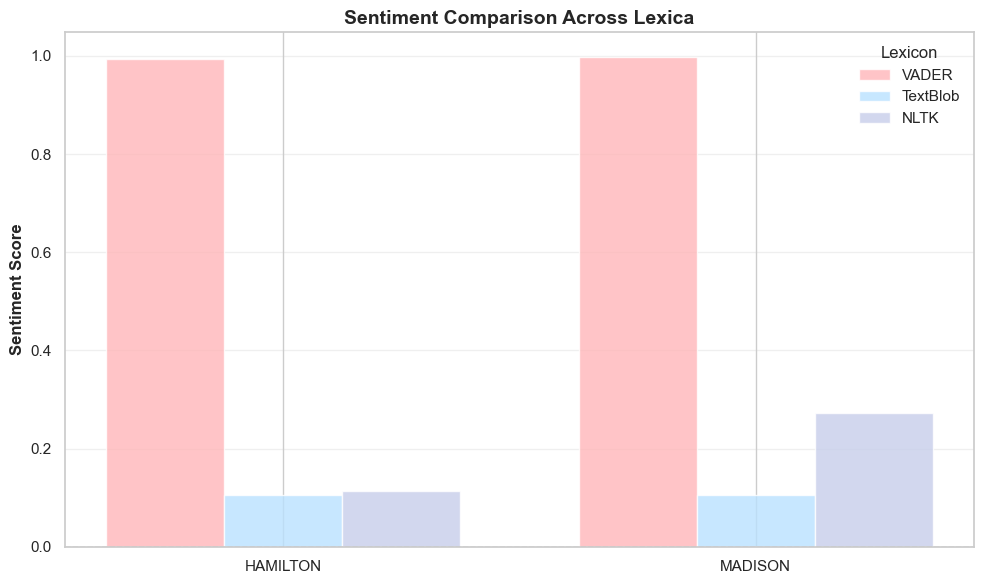

In [32]:
# Get only known authors for comparison
x = np.arange(len(authors_list))
width = 0.25

# Normalize sentiment scores
vader_normalized = author_summary.loc[authors_list, 'vader_compound']  # Already in -1 to +1 range
textblob_normalized = author_summary.loc[authors_list, 'textblob_polarity']
nltk_normalized = author_summary.loc[authors_list, 'nltk_sentiment'] / 20  # Scale for visibility

plt.figure(figsize=(10, 6))
plt.bar(x - width, vader_normalized, width, label='VADER', color='#FFB6B9', alpha=0.8)
plt.bar(x, textblob_normalized, width, label='TextBlob', color='#BAE1FF', alpha=0.8)
plt.bar(x + width, nltk_normalized, width, label='NLTK', color='#C7CEEA', alpha=0.8)

plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Comparison Across Lexica', fontsize=14, fontweight='bold')
plt.xticks(x, authors_list)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(title='Lexicon')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


VADER shows overwhelmingly positive sentiment for both authors, while TextBlob and NLTK suggest more moderate emotional tone. This highlights how different lexicons weight context, with VADER amplifying positivity more than the others. The interesting pattern here is that contextual methods (VADER and TextBlob) rank Hamilton as more positive, while the bag-of-words method (NLTK) ranks Madison as more positive. This difference suggests that the two authors use language differently in ways that these methods capture differently.

TextBlob Subjectivity

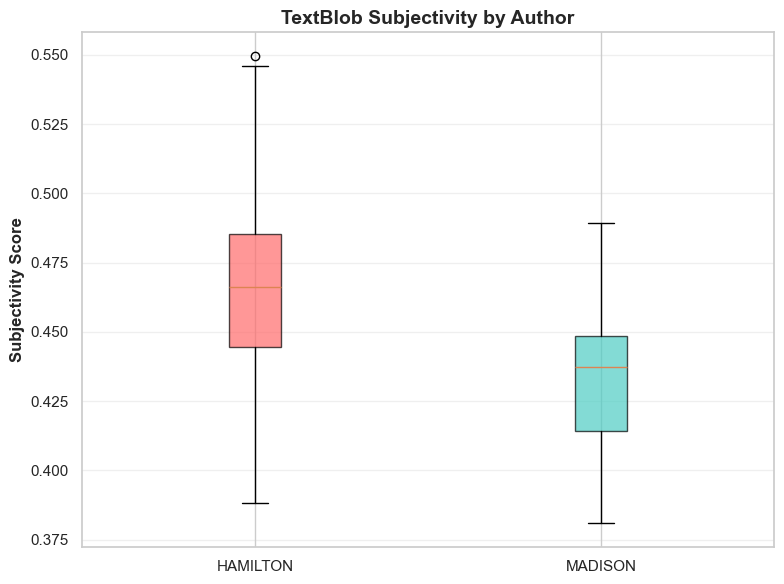

In [33]:

subjectivity_data = [
    known_papers[known_papers['author'] == author]['textblob_subjectivity']
    for author in authors_list
]

plt.figure(figsize=(8, 6))
bp = plt.boxplot(subjectivity_data, labels=authors_list, patch_artist=True)

# Color each box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Subjectivity Score', fontsize=12, fontweight='bold')
plt.title('TextBlob Subjectivity by Author', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Hamilton more sujective while Madison more factual

NLTK Positive vs Negative

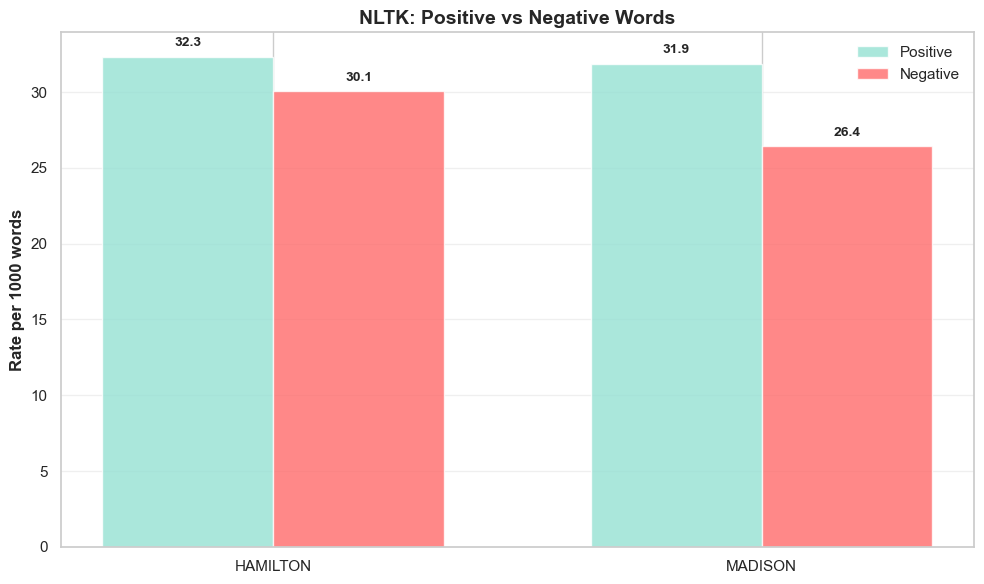

In [35]:

x_pos = np.arange(len(authors_list))
width = 0.35

# Extract mean positive/negative rates
positive_rates = [author_sentiment.loc[author, ('nltk_positive_rate', 'mean')] for author in authors_list]
negative_rates = [author_sentiment.loc[author, ('nltk_negative_rate', 'mean')] for author in authors_list]

plt.figure(figsize=(10, 6))
bars_pos = plt.bar(x_pos - width/2, positive_rates, width, label='Positive', color='#95E1D3', alpha=0.8)
bars_neg = plt.bar(x_pos + width/2, negative_rates, width, label='Negative', color='#FF6B6B', alpha=0.8)

# Add numbers on top of bars
for bar in bars_pos + bars_neg:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.5,  # position
        f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.ylabel('Rate per 1000 words', fontsize=12, fontweight='bold')
plt.title('NLTK: Positive vs Negative Words', fontsize=14, fontweight='bold')
plt.xticks(x_pos, authors_list)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Hamilton uses more negative words than Madison (30.1 vs 26.4 per 1000 words), while positive words is almost same. This 2 word-per-1000 difference in negative word usage explains why Hamilton's net NLTK sentiment (2.3) lower than Madison's (5.4). The question is whether these negative words are being used in negative contexts, or if Hamilton is using constructions like "not bad" that NLTK would count as negative but are actually positive.

Lets do now enhanced NLTK analysis with basic negation handling

In [41]:
def count_opinion_words_with_negation(text, pos_words, neg_words):
    # Count sentiment words while handling simple negations
    words = text.lower().split()
    negation_words = {'not', 'no', 'never', 'neither', 'nobody', 'nothing', 
                      'nowhere', 'hardly', 'scarcely', 'barely', 'without'}
    
    positive_count = 0
    negative_count = 0
    
    for i, word in enumerate(words):
        # Check if previous 1-2 words contain negation
        is_negated = False
        if i > 0 and words[i-1] in negation_words:
            is_negated = True
        elif i > 1 and words[i-2] in negation_words:
            is_negated = True
            
        if word in pos_words:
            if is_negated:
                negative_count += 1  # "not good" becomes negative
            else:
                positive_count += 1
        elif word in neg_words:
            if is_negated:
                positive_count += 1  # "not bad" becomes positive
            else:
                negative_count += 1
    
    return positive_count, negative_count

# Apply enhanced analysis
opinion_results_enhanced = federalist['clean_text'].apply(
    lambda x: count_opinion_words_with_negation(x, positive_words_nltk, negative_words_nltk)
)

federalist['nltk_enhanced_pos_count'] = opinion_results_enhanced.apply(lambda x: x[0])
federalist['nltk_enhanced_neg_count'] = opinion_results_enhanced.apply(lambda x: x[1])

# Calculate enhanced rates
federalist['nltk_enhanced_pos_rate'] = (federalist['nltk_enhanced_pos_count'] / federalist['text_length']) * 1000
federalist['nltk_enhanced_neg_rate'] = (federalist['nltk_enhanced_neg_count'] / federalist['text_length']) * 1000
federalist['nltk_enhanced_sentiment'] = federalist['nltk_enhanced_pos_rate'] - federalist['nltk_enhanced_neg_rate']


Compare basic vs enhanced for known authors

In [44]:

known_papers_enhanced = federalist[federalist['author'].isin(['HAMILTON', 'MADISON'])]

enhanced_comparison = known_papers_enhanced.groupby('author').agg({
    'nltk_sentiment': 'mean',
    'nltk_enhanced_sentiment': 'mean'
}).round(3)


display(enhanced_comparison)

,nltk_sentiment,nltk_enhanced_sentiment
author,,
HAMILTON,2.269,2.924
MADISON,5.449,6.018


Plot the difference

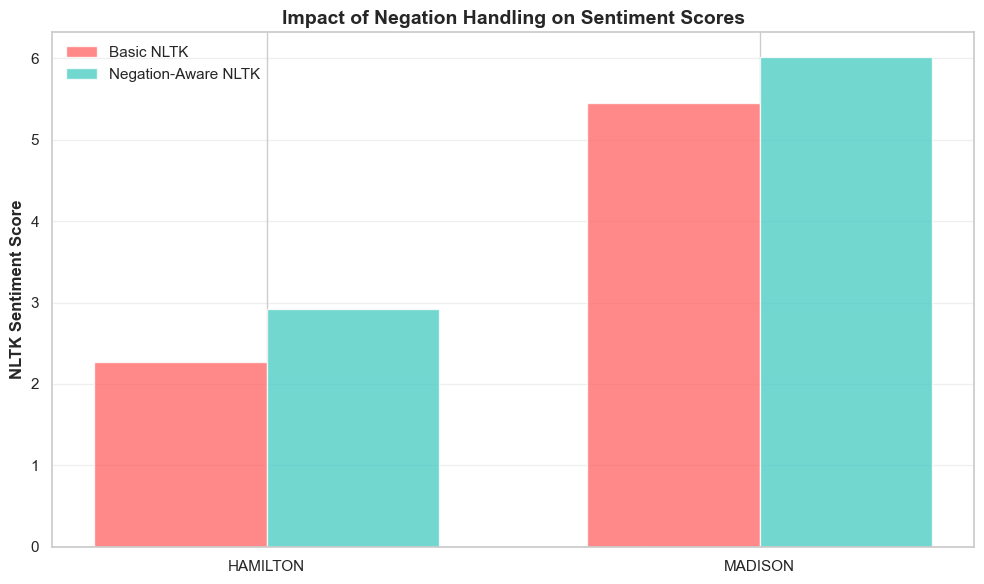

In [45]:
x_pos = np.arange(len(authors_list))
width = 0.35

basic_scores = [enhanced_comparison.loc[a, 'nltk_sentiment'] for a in authors_list]
enhanced_scores = [enhanced_comparison.loc[a, 'nltk_enhanced_sentiment'] for a in authors_list]

plt.figure(figsize=(10, 6))
plt.bar(x_pos - width/2, basic_scores, width, label='Basic NLTK', color='#FF6B6B', alpha=0.8)
plt.bar(x_pos + width/2, enhanced_scores, width, label='Negation-Aware NLTK', color='#4ECDC4', alpha=0.8)

plt.ylabel('NLTK Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Impact of Negation Handling on Sentiment Scores', fontsize=14, fontweight='bold')
plt.xticks(x_pos, authors_list)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

When negations were handled both Hamilton and Madison improve by about the same amount (around 0.6 points each). This means that negations don't explain why Hamilton's NLTK score is lower than Madison's. The gap stays about the same. So it turns out that Hamilton really does use more negative words than Madison, not just negated forms like "not bad". But VADER and TextBlob still rank Hamilton as more positive, which suggests that Hamilton uses these negative words in ways that contribute to positive arguments overall. He might be using them to criticize opposing positions or to set up contrasts that support his main points. This is actually a more interesting finding than if negations had explained everything. It shows that Hamilton has a more sophisticated argumentative style where he deploys negative vocabulary strategically within positive rhetorical frameworks. Contextual methods like VADER and TextBlob can pick up on this discourse-level positivity, while simple word counting methods like NLTK just see the negative words themselves.